In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gökçe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\ProgramData\Miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import openpyxl
from gensim.models import CoherenceModel
import tqdm

In [3]:
wb = openpyxl.load_workbook('il_ilceler.xlsx')
il = wb.get_sheet_by_name('Iller')
il = wb.active
il_List = []   
for cell in il['B']:
    il_List.append(str(cell.value))

wb = openpyxl.load_workbook('ilceler.xlsx')
ilce = wb.active
ilce_List = []   
for cell in ilce['A']:
    ilce_List.append(str(cell.value))

önceki_karakterler =      ["ş",
                          "ç",
                          "ö",
                          "ğ",
                          "ü",
                          "ı",
                          "Ş",
                          "Ç",
                          "Ö",
                          "Ğ",
                          "Ü",
                          "İ"]

sonraki_karakterler =   ["s",
                         "c",
                         "o",
                         "g",
                         "u",
                         "i",
                         "S",
                         "C",
                         "O",
                         "G",
                         "U",
                         "I"]

for i in range(len(il_List)):
    il_List[i]= il_List[i].lower()
    for a in range(12):
        il_List[i]=il_List[i].replace(önceki_karakterler[a],sonraki_karakterler[a])
for i in range(len(ilce_List)):
    ilce_List[i]= ilce_List[i].lower()
    for a in range(12):
        ilce_List[i]=ilce_List[i].replace(önceki_karakterler[a],sonraki_karakterler[a])

il_ilce= il_List +ilce_List + ["turkey"]

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(il_ilce)

In [5]:
df = pd.read_excel("national2.xlsx")

In [6]:
df.head()

,National or Local?,Document Type / Title,Date of the publication,Main Policy Actor,The Actual Text (1 paragraph summary text carrying the main themes in the document)
0,1,National Environment Action Plan of Turkey,1999,The State Planning Organization,"In general, the benefits of the NEAP will incl..."
1,1,8th National Development Plan (2001-2005) Spec...,2000,The State Planning Organization,The main objective of Turkey's environmental p...
2,1,National Action Plan to Combat Desertification,2005,Ministry of Environment and Forestry,Turkey's rapid population growth and movements...
3,1,9th National Development Plan-Special Commissi...,2007,The State Planning Organization,Living in a healthy environment is a primary h...
4,1,Report of Parliamentary Investigation Commissi...,2007,Parliamentary Investigation Commission,In order to investigate the effects of global ...


In [7]:
data= df["The Actual Text (1 paragraph summary text carrying the main themes in the document)"]

In [8]:
# Remove punctuation
data.map(lambda x: re.sub('[,\.!?;/]', '', x))
# Convert the titles to lowercase
data = \
data.map(lambda x: x.lower())
# Print out the first rows of papers
data.head()
data = data.values.tolist()

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['in', 'general', 'the', 'benefits', 'of', 'the', 'neap', 'will', 'include', 'better', 'health', 'for', 'the', 'citizens', 'of', 'turkey', 'increased', 'economic', 'productivity', 'more', 'efficient', 'use', 'of', 'existing', 'public', 'sector', 'resources', 'and', 'natural_resources', 'improved', 'sustainability', 'of', 'natural', 'ecosystems', 'and', 'increased', 'amenity', 'benefits', 'an', 'indication', 'of', 'the', 'magnitude', 'of', 'these', 'benefits', 'can_be', 'drawn', 'from', 'the', 'existing', 'data', 'presented', 'in', 'this', 'synthesis', 'report', 'imple', 'mentation', 'of', 'the', 'neap', 'could', 'achieve', 'some', 'of', 'the', 'following', 'saving', 'lives', 'per', 'year', 'by', 'reducing', 'particulate', 'matter', 'and', 'so', 'levels', 'to', 'who', 'standarts', 'reducing', 'total', 'health', 'costs', 'by', 'million', 'each', 'year', 'by', 'the', 'same', 'measures', 'conserving', 'billion', 'of', 'drinking', 'water', 'per', 'year', 'if', 'losses', 'in', 'the', 'public

In [11]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['general', 'benefit', 'neap', 'include', 'well', 'health', 'citizen', 'increase', 'economic', 'productivity', 'efficient', 'use', 'exist', 'public', 'sector', 'resource', 'improve', 'sustainability', 'natural', 'ecosystem', 'increase', 'amenity', 'benefit', 'indication', 'magnitude', 'benefit', 'draw', 'exist', 'datum', 'present', 'synthesis', 'report', 'imple', 'mentation', 'neap', 'achieve', 'follow', 'save', 'life', 'year', 'reduce', 'particulate', 'matter', 'level', 'standart', 'reduce', 'total', 'health', 'cost', 'year', 'measure', 'conserve', 'drinking', 'water', 'year', 'loss', 'public', 'distribution', 'network', 'cut', 'half', 'recapture', 'ton', 'soil', 'ton', 'plant', 'nutrient', 'lose', 'year', 'due', 'erosion', 'extend', 'economic', 'life', 'dam', 'hydropow', 'plant', 'reduce', 'sedimentation', 'save', 'ton', 'illegally', 'harvest', 'wood', 'year', 'substitute', 'fuel', 'increase', 'efficiency', 'preserve', 'specie', 'threat', 'extinction', 'save', 'life', 'lose', 'avera

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 3), (36, 1), (37, 1), (38, 4), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 2), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 3), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 6)]]


#do not need to build the model again as we have log files and we have already got the results. Stop here. 

In [49]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=10,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"country" + 0.022*"climate" + 0.013*"energy" + 0.013*"action" + '
  '0.013*"study" + 0.011*"take" + 0.011*"list" + 0.011*"market" + '
  '0.011*"intervention" + 0.011*"agriculture"'),
 (1,
  '0.030*"energy" + 0.023*"city" + 0.019*"increase" + 0.018*"environment" + '
  '0.014*"life" + 0.012*"use" + 0.012*"resource" + 0.009*"year" + '
  '0.009*"waste" + 0.008*"environmental"'),
 (2,
  '0.001*"country" + 0.001*"development" + 0.001*"green_growth" + '
  '0.001*"human" + 0.001*"quality" + 0.001*"vision" + 0.001*"program" + '
  '0.001*"sustainable_development" + 0.001*"life" + 0.001*"increase"'),
 (3,
  '0.021*"drought" + 0.019*"management" + 0.019*"study" + 0.019*"publication" '
  '+ 0.016*"take" + 0.016*"risk" + 0.013*"effect" + 0.013*"future" + '
  '0.013*"natural" + 0.011*"include"'),
 (4,
  '0.025*"development" + 0.016*"natural_resource" + 0.013*"environment" + '
  '0.013*"environmental" + 0.013*"policy" + 0.013*"human" + 0.010*"national" + '
  '0.010*"soil" + 0.010*"climat

In [50]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.996045582392365

Coherence Score:  0.4216360039824959


In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=750,chunksize=100,passes=10,)

        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                            passes=10,
                                           alpha=0.91,
                                           eta='symmetric',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=12, limit=40, step=2)

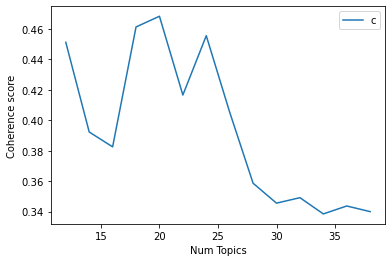

In [26]:
import matplotlib.pyplot as plt
limit=40; start=12; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [27]:
coherence_values

[0.45123984308591836,
 0.3923351056875983,
 0.3825749719368629,
 0.46132765293734423,
 0.4683700453416197,
 0.41662453929995497,
 0.45558358025453877,
 0.40533960609526054,
 0.35866647129945806,
 0.34557966610436236,
 0.3491882194865701,
 0.33851524096688257,
 0.34372849475340567,
 0.34002235130958364]

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

In [24]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"study" + 0.022*"desertification" + 0.014*"climate" + 0.014*"country" '
  '+ 0.013*"risk" + 0.012*"publication" + 0.011*"natural" + 0.011*"program" + '
  '0.010*"action" + 0.010*"drought"'),
 (1,
  '0.033*"energy" + 0.023*"city" + 0.021*"environment" + 0.019*"increase" + '
  '0.013*"resource" + 0.013*"life" + 0.011*"use" + 0.009*"waste" + '
  '0.009*"target" + 0.009*"year"'),
 (2,
  '0.001*"country" + 0.001*"increase" + 0.001*"climate_change" + '
  '0.001*"management" + 0.001*"energy" + 0.001*"national" + 0.001*"water" + '
  '0.001*"use" + 0.001*"environment" + 0.001*"development"'),
 (3,
  '0.018*"main" + 0.017*"fulfill" + 0.015*"protection" + 0.015*"good" + '
  '0.015*"national" + 0.015*"service" + 0.014*"work" + 0.013*"park" + '
  '0.013*"strategic" + 0.013*"forest"'),
 (4,
  '0.024*"national" + 0.020*"city" + 0.020*"strategy" + 0.018*"drought" + '
  '0.016*"take" + 0.015*"policy" + 0.014*"sustainable" + 0.013*"include" + '
  '0.012*"development" + 0.011*"management"')

In [13]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [14]:
#to be able to choose the best model

import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 11
max_topics = 35
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               #corpus]
#corpus_title = ['75% Corpus', '100% Corpus'], 'Validation_Set': [],
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    #for i in range(len(corpus_sets)):
        # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                                k=k, a=a, b=b)
                # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)


                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_national.csv', index=False)
    pbar.close()

 67%|██████▋   | 360/540 [1:28:26<44:13, 14.74s/it]  


In [14]:
#results of tuning part
df3= pd.read_csv("lda_tuning_results_national.csv")

In [15]:
df3.sort_values(by=["Coherence"],ascending=False).head(20)

,Topics,Alpha,Beta,Coherence
139,19,0.9099999999999999,symmetric,0.489749
134,19,0.61,symmetric,0.487982
135,19,0.9099999999999999,0.01,0.476209
148,19,asymmetric,0.9099999999999999,0.475653
105,17,0.9099999999999999,0.01,0.472539
109,17,0.9099999999999999,symmetric,0.471279
130,19,0.61,0.01,0.468373
16,11,0.9099999999999999,0.31,0.465808
359,33,asymmetric,symmetric,0.459641
140,19,symmetric,0.01,0.455634


In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=19, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta="auto",
                                           per_word_topics=True)

In [17]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.226454276655345

Coherence Score:  0.4897491686315812


In [170]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\gökçe\AppData\Local\Temp\ipykernel_10544\1000666203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\gökçe\AppData\Local\Temp\ipykernel_10544\1000666203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8076,"energy, city, environment, increase, resource,...","[general, benefit, neap, include, well, health..."
1,1,4,0.7469,"national, city, strategy, drought, take, polic...","[main, objective, environmental, policy, deter..."
2,2,0,0.8458,"study, desertification, climate, country, risk...","[rapid, population, growth, movement, process,..."
3,3,6,0.8752,"development, natural_resource, program, soil, ...","[live, healthy, environment, primary, human, r..."
4,4,18,0.3776,"water, increase, take, measure, country, droug...","[order, investigate, effect, global_warme, det..."
5,5,18,0.6790,"water, increase, take, measure, country, droug...","[foresee, global_warming, affect, country, par..."
6,6,1,0.1890,"energy, city, environment, increase, resource,...","[increase, environmental, problem, world, star..."
7,7,9,0.9168,"energy, country, supply, resource, production,...","[prepare, strategic, plan, cover, year, perspe..."
8,8,18,0.7760,"water, increase, take, measure, country, droug...","[frame, climate_change, inventory, greenhouse_..."
9,9,5,0.7376,"system, settlement, planning, environmental, m...","[kentge, cover, area, theme, dimension, settle..."


In [ ]:
# the topic numbers are not compatible with the topic numbers in plydavis graph. So, I made the chages below
a=[1,5,3,10,7,7,1,6,7,8,1,4,2,11,2,9,2,12,1,3,3,4,3,5,8,2,4,14,13,1,1,1,1,5,5,2,3]
df_topic_sents_keywords["Dominant_Topic"]= a
df_dominant_topic["Document Title"] = df["Document Type / Title"]
df_dominant_topic.to_csv('national_dominant_topics_fin.csv')  
df_dominant_topic["Dominant_Topic"] = a

In [190]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)
#sent_topics_sorteddf_mallet.to_csv('local_textsum_topics_and_representatives.csv')  

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8610,"study, desertification, climate, country, risk, publication, natural, program, action, drought","[observation, forecasting, study, show, geographical, difference, frequency, impact, level, seve..."
1,1,0.9060,"energy, city, environment, increase, resource, life, use, waste, target, year","[ministry, environment, urbanization, new, era, continue, service, activity, field, nature, envi..."
2,3,0.7727,"main, fulfill, protection, good, national, service, work, park, strategic, forest","[decree, law, date, organization, duty, work, establish, determine, national, international, pol..."
3,4,0.8658,"national, city, strategy, drought, take, policy, sustainable, include, development, management","[smart, city, strategy, first, world, fourth, smart, city, strategy, prepare, national, level, s..."
4,5,0.9048,"system, settlement, planning, environmental, management, plan, ensure, pollution, principle, bui...","[strategic, plan, underline, way, create, brand, city, create, environmentally, friendly, city, ..."
5,6,0.8752,"development, natural_resource, program, soil, country, deplete, decrease, live, environmental, c...","[live, healthy, environment, primary, human, right, climate, change, due, global_warming, drough..."
6,8,0.9169,"effort, global, national, development, international, common, principle, capacity, adaptation, m...","[primary, objective, scope, global, combat, climate_change, participate, global, effort, carry, ..."
7,9,0.9168,"energy, country, supply, resource, production, market, reduce, increase, plan, strategic","[prepare, strategic, plan, cover, year, perspective, country, policy, energy, strategic, plan, p..."
8,10,0.8602,"climate_change, adaptation, strategy, impact, water_resource, national, term, forest, ecosystem,...","[accord, scientific, evidence, nature, conservation, experience, protected_area, essential, part..."
9,13,0.4235,"waste, waste_management, prepare, current_situation, municipality, investment, recovery, collect...","[document, prepare, line, implementation, national, legislation, scope, plan, aim, analyze, curr..."


In [ ]:
#You can find the topics represented in Plydavis graph and the keywords here

topics = lda_model.show_topics(num_topics=19)
topics[0][0] =3
topics[1][0] = 1
topics[2][0]=19
topics[3][0] =12
topics[4][0] =5
topics[5][0] =8
topics[6][0] =10
topics[7][0] =15
topics[8][0] = 9
topics[9][0] =6
topics[10][0] =2
topics[11][0] = 17
topics[12][0]=16
topics[13][0] =13
topics[14][0] =18
topics[15][0] =11
topics[16][0] =4
topics[17][0] =14
topics[18][0] = 7

topics


In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

my_stop_words = STOPWORDS.union(set(il_ilce))
#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=my_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=12,
                  colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#topics = lda_model.show_topics(num_topics=22,formatted=False)

fig, axes = plt.subplots(4, 3, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(topics[i][0]), fontdict=dict(size=16))
    plt.gca().axis('off')
    isim='national_wordcloud'+ str(topics[i][0])+".png"
    cloud.to_file(isim)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

You may continuw from here to see the results. By running the codes below
    you can draw pyldavis graph by reading the log fil of lda resuts. 
    you can find the dataframes of the results by reading the csv files prepared with the code above.


In [14]:
from gensim.test.utils import datapath



#saving model to disk.

temp_file = datapath("D:\gökçe\Documents\climate narratives\lda_national")

#lda_model.save(temp_file)



#loading model from disk

from gensim import  models

lda_model = models.ldamodel.LdaModel.load(temp_file)

In [15]:
dominant_topics= pd.read_csv('national_dominant_topics_fin.csv')
representatives= pd.read_csv('representatives_topics_national.csv')

In [16]:
dominant_topics.head()

,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document Title
0,0,0,1,0.8076,"energy, city, environment, increase, resource,...","['general', 'benefit', 'neap', 'include', 'wel...",National Environment Action Plan of Turkey
1,1,1,5,0.7469,"national, city, strategy, drought, take, polic...","['main', 'objective', 'environmental', 'policy...",8th National Development Plan (2001-2005) Spec...
2,2,2,3,0.8458,"study, desertification, climate, country, risk...","['rapid', 'population', 'growth', 'movement', ...",National Action Plan to Combat Desertification
3,3,3,10,0.8752,"development, natural_resource, program, soil, ...","['live', 'healthy', 'environment', 'primary', ...",9th National Development Plan-Special Commissi...
4,4,4,7,0.3776,"water, increase, take, measure, country, droug...","['order', 'investigate', 'effect', 'global_war...",Report of Parliamentary Investigation Commissi...


In [17]:
representatives

,Unnamed: 0,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,1,0.9060,"energy, city, environment, increase, resource,...","['ministry', 'environment', 'urbanization', 'n..."
1,1,2,0.8602,"climate_change, adaptation, strategy, impact, ...","['accord', 'scientific', 'evidence', 'nature',..."
2,2,3,0.8610,"study, desertification, climate, country, risk...","['observation', 'forecasting', 'study', 'show'..."
3,3,4,0.8845,"plan, climate_change, increase, expect, accord...","['innovate', 'sustanable', 'additional', 'fina..."
4,4,5,0.8658,"national, city, strategy, drought, take, polic...","['smart', 'city', 'strategy', 'first', 'world'..."
5,5,6,0.9168,"energy, country, supply, resource, production,...","['prepare', 'strategic', 'plan', 'cover', 'yea..."
6,6,7,0.7760,"water, increase, take, measure, country, droug...","['frame', 'climate_change', 'inventory', 'gree..."
7,7,8,0.9048,"system, settlement, planning, environmental, m...","['strategic', 'plan', 'underline', 'way', 'cre..."
8,8,9,0.9169,"effort, global, national, development, interna...","['primary', 'objective', 'scope', 'global', 'c..."
9,9,10,0.8752,"development, natural_resource, program, soil, ...","['live', 'healthy', 'environment', 'primary', ..."


In [18]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
LDAvis_prepared

c:\ProgramData\Miniconda3\envs\myenv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.239161  0.110882       1        1  15.940118
10    -0.124880  0.159735       2        1  12.441854
0      0.014273 -0.277626       3        1  11.041234
16     0.070901  0.253850       4        1   9.300383
4     -0.164050 -0.192205       5        1   8.537390
9     -0.243157  0.146222       6        1   6.657973
18    -0.052638  0.255583       7        1   6.245839
5      0.250834 -0.030616       8        1   6.150418
8     -0.259413 -0.032432       9        1   5.475272
6      0.130591  0.138474      10        1   3.489449
15    -0.164077 -0.027550      11        1   3.376368
3     -0.064742 -0.143516      12        1   2.405198
13     0.147045 -0.180905      13        1   2.302929
17    -0.052089 -0.004657      14        1   1.895373
7      0.056344 -0.085923      15        1   1.329862
12     0.092922 -0.040483      16        1   1.074821
11     0.060542 -0.001999      17        1   0.998442
14     0.032678 -0.024554      18        1   0.700411
2      0.029754 -0.022280      19        1   0.636665, topic_info=               Term       Freq      Total Category  logprob  loglift
429          energy  54.000000  54.000000  Default  30.0000  30.0000
496           waste  18.000000  18.000000  Default  29.0000  29.0000
495  transportation  16.000000  16.000000  Default  28.0000  28.0000
131         prepare  17.000000  17.000000  Default  27.0000  27.0000
243            city  28.000000  28.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
373            risk   0.029426  19.198005  Topic19  -6.8930  -1.4240
60         resource   0.029532  22.762494  Topic19  -6.8894  -1.5907
387         develop   0.029479  22.186906  Topic19  -6.8912  -1.5669
129            plan   0.029791  31.982341  Topic19  -6.8806  -1.9221
243            city   0.029080  28.694004  Topic19  -6.9048  -1.8377

[1097 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
330       7  0.850152          able
737       2  0.647538      academia
234      10  0.672124  acceleration
399       6  0.612388    accomplish
295       2  0.188779        accord
...     ...       ...           ...
80        5  0.184016          year
80        6  0.122677          year
80        7  0.061339          year
80       11  0.061339          year
80       14  0.061339          year

[1677 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 1, 17, 5, 10, 19, 6, 9, 7, 16, 4, 14, 18, 8, 13, 12, 15, 3])

In [19]:
pyldavis_dict2 = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=True, mds='mmds').to_dict()


c:\ProgramData\Miniconda3\envs\myenv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [20]:
df_token = pd.DataFrame.from_dict(pyldavis_dict2['token.table'])
df_term = pd.DataFrame.from_dict(pyldavis_dict2['tinfo'])
df_topic = pd.DataFrame.from_dict(pyldavis_dict2['mdsDat'])

In [21]:
dict_df_term2 = {}
topic_num=20
for i in range(1,topic_num):
    find = "Topic"+str(i)
    df_term2 = df_term[df_term['Category'] == find ].sort_values(by=['Freq'],ascending=False)
    dict_df_term2[find] = df_term2["Term"].to_list()

In [24]:
df_topic_keywords = pd.DataFrame( columns=['Topics', 'Keywords', 'Frequencies(BubleSize)'])
df_topic_keywords['Topics']= dict_df_term2.keys()
df_topic_keywords['Keywords'] = dict_df_term2.values()
df_topic_keywords['Frequencies(BubleSize)'] = df_topic['Freq']

In [26]:
#df_topic_keywords.to_csv('national_buble_size.csv')  
df_topic_keywords

,Topics,Keywords,Frequencies(BubleSize)
0,Topic1,"[energy, city, environment, increase, resource...",15.940277
1,Topic2,"[climate_change, adaptation, strategy, impact,...",12.441784
2,Topic3,"[study, desertification, climate, country, ris...",11.041212
3,Topic4,"[plan, climate_change, increase, expect, accor...",9.300719
4,Topic5,"[national, city, strategy, drought, take, poli...",8.537099
5,Topic6,"[energy, country, supply, resource, production...",6.657848
6,Topic7,"[water, increase, take, measure, country, drou...",6.245458
7,Topic8,"[system, settlement, planning, environmental, ...",6.150570
8,Topic9,"[effort, global, national, development, intern...",5.475558
9,Topic10,"[development, natural_resource, program, soil,...",3.489501
